## Panel dyskusyjny agentów

### Instalacja bibliotek

In [31]:
!pip install -U dotenv langchain_core langgraph langgraph-supervisor langchain-tavily

In [43]:
from langchain_core.messages import convert_to_messages
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState, create_react_agent
from langgraph.graph import StateGraph, START, MessagesState, END
from langgraph.types import Command

from dotenv import load_dotenv
load_dotenv()

True

In [44]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("Kto jest prezydentem Polski?")

print(web_search_results["results"][0]["content"])

### **Arkadiusz Chęciński** Karol Nawrocki został nowym prezydentem Polski. I teraz najważniejsze pytanie brzmi: czy nowy prezydent będzie potrafił te dwie połówki zespolić? Jasny i czytelny, Rafał Trzaskowski 60,35%, Karol Nawrocki 39,65%. Z Was. Z frekwencji. Image 2 Image 3 Image 4 Image 5: 🫣 Arkadiusz Chęciński smutek to mało powiedziane. View all 38 replies Wstyd, kryminalista będzie twarzą Polski Image 12: 😳 View all 16 replies View all 3 replies Image 22Image 23 View all 6 replies Image 24 Image 25 View all 2 replies I teraz najważniejsze pytanie brzmi: czy nowy prezydent będzie potrafił te dwie połówki zespolić?” - To chyba najważniejszy fragment z pana posta, Panie Prezydencie. Image 26 View all 6 replies View all 32 replies View all 2 replies


### Funkcje pomocnicze

In [34]:
def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

### Agent researcher

In [35]:
research_agent = create_react_agent(
    model="openai:gpt-5-mini",
    tools=[web_search],
    prompt=(
     "Jesteś Researcherem. Masz dostęp do wyników wyszukiwarki (RESEARCH).\n"
     "Twoim celem jest dostarczyć rzeczowe, krótkie fakty i dane wspierające temat.\n"
     "Odnoś się do fragmentów i nie fantazjuj. Pisz po polsku, zwięźle."
        "- Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora\n"
        "- Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."
    ),
    name="research_agent",
)

### Agent ekspert

In [36]:
expert_agent = create_react_agent(
    model="openai:gpt-5-mini",
    tools=[],
    prompt=(
       "Jesteś Ekspertem. Z dostępnych faktów zaproponuj praktyczne rozwiązanie/plan.\n"
       "Uwzględnij kroki, wymagania i minimalny zestaw decyzji. Pisz po polsku, konkretnie."
        "- Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora\n"
        "- Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."
    ),
    name="expert_agent",
)

### Agent krytyk

In [37]:
critic_agent = create_react_agent(
    model="openai:gpt-5-mini",
    tools=[],
    prompt=(
     "Jesteś Krytykiem. Twoją rolą jest znaleźć luki, ryzyka i niejasności w propozycji.\n"
     "Zadawaj dociekliwe pytania i wskaż brakujące elementy. Bądź konstruktywny."
        "- Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora\n"
        "- Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."
    ),
    name="critic_agent",
)

In [38]:
def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            goto=agent_name,
            update={**state, "messages": state["messages"] + [tool_message]},
            graph=Command.PARENT,
        )

    return handoff_tool

# Handoffs
assign_to_research_agent = create_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_expert_agent = create_handoff_tool(
    agent_name="expert_agent",
    description="Assign task to a expert agent.",
)

assign_to_critic_agent = create_handoff_tool(
    agent_name="critic_agent",
    description="Assign task to a critic agent.",
)

### Agent moderator

In [39]:
supervisor_agent = create_react_agent(
    model="openai:gpt-5-mini",
    tools=[assign_to_research_agent, assign_to_expert_agent, assign_to_critic_agent],
    prompt=(
        "Jesteś Moderatorem dyskusji w której biorą udział 3 agenci: Researcher, Krytyk i Ekspert . Decydujesz, czy kończymy, czy kontynuujemy.\n"
        "Jeśli kontynuujemy, podaj KRÓTKIE kolejne zapytanie badawcze (research_query) "
        "dla Researchera, Krytyka lub Eksperta. Pisz po polsku. Jeżeli kończymy podsumuj dyskusję i przedstaw w utrukturyzowany i czytelny sposób odpowiedź na pytanie."
        "- Researcher. Wyszukuje informacje i podaje fakty, które stanowią podstawe dalszej dyskucji\n"
        "- Krytyk. Patrzy asertywnie na dotychczasowe wnioski i wskazuje słabe punkty i elemanty do zmiany lub poprawienia\n"
        "- Ekspert. Wyciąga wnioski i stawia tezy. Stara się rozwiązać zadanie na podstawie informacji otrzyumanych od Researchera i Krytyka\n"
        "Przypisz pracę jednemu agentowi naraz, nie wywołuj agentów równolegle.\n"
        "Samodzielnie nie bierz udziału w dyskusji pracy."
    ),
    name="supervisor",
)

### Budowa grafu

In [40]:
supervisor = (
    StateGraph(MessagesState)
    .add_node(supervisor_agent, destinations=("research_agent", "expert_agent", "critic_agent", END))
    .add_node(research_agent)
    .add_node(expert_agent)
    .add_node(critic_agent)
    .add_edge(START, "supervisor")
    .add_edge("research_agent", "supervisor")
    .add_edge("expert_agent", "supervisor")
    .add_edge("critic_agent", "supervisor")
    .compile()
)

### Wyświetl graf

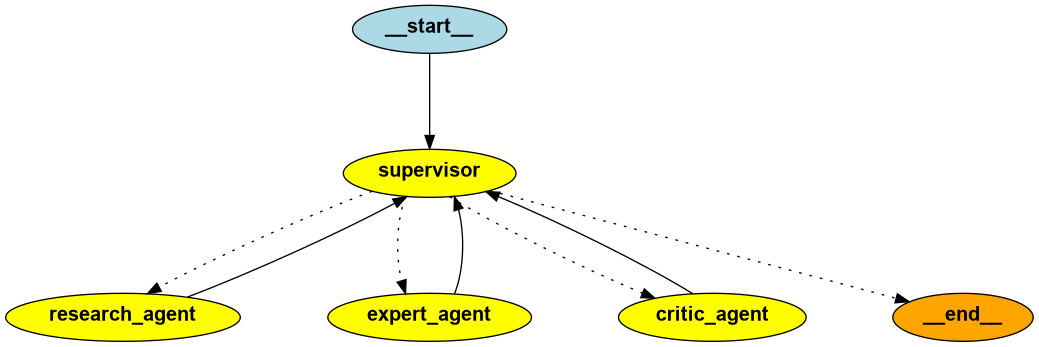

In [41]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_png()))

### Przeprowadź dyskusję na zadany temat i wyświetl odpowiedź

In [42]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content":" Jakiej dziedziny najlepiej uczyć się, żeby mieć dobrze płatny i interesujący zawód za 10 lat.",
            }
        ]
    },

    subgraphs=True,
):
    pretty_print_messages(chunk, last_message=True)

Update from subgraph supervisor:


	Update from node agent:


	================================== Ai Message ==================================
	Name: supervisor
	Tool Calls:
	  transfer_to_research_agent (call_4IPankXAvaUTdN2lp6usAuxM)
	 Call ID: call_4IPankXAvaUTdN2lp6usAuxM
	  Args:


Update from subgraph research_agent:


	Update from node agent:


	================================== Ai Message ==================================
	Name: research_agent
	Tool Calls:
	  tavily_search (call_9fMoh6yfQ9Vgd5QeiF8K6Jtw)
	 Call ID: call_9fMoh6yfQ9Vgd5QeiF8K6Jtw
	  Args:
	    query: World Economic Forum Future of Jobs 2023 top skills 2030 report
	    search_depth: advanced
	    topic: general
	  tavily_search (call_gB6Hs6SbUejAYnRZfcdTi4SD)
	 Call ID: call_gB6Hs6SbUejAYnRZfcdTi4SD
	  Args:
	    query: LinkedIn Emerging Jobs 2024 AI data scientist cybersecurity report 2024 2025
	    search_depth: advanced
	    topic: general
	  tavily_search (call_xetoqQUfCGUla5e4SN5ZPWu1)
	 Call ID: call_xeto